#Programming Assignment 5: Building a Movie Recommendation System

###Team Details:

When submitting, fill your team details in this cell. Note that this is a markdown cell.

**Student 1 Full Name:** Sreehari Balakrishna Hegden
**Student 1 Student ID:** 1001109610
**Student 1 Email Address:** sreehari.hegden@mavs.uta.edu

**Student 2 Full Name:** Sumesh Nellemakkal Balan
**Student 2 Student ID:** 1001119408
**Student 2 Email Address:** sumesh.nellemakkalbalan@mavs.uta.edu  

**Student 3 Full Name:** Divya Maria Jose
**Student 3 Student ID:** 1000989859
**Student 3 Email Address:** divya.jose@mavs.uta.edu

##Assignment Details

In this assignment, we will explore some of the fundamental concepts in building a recommendation systems for movies. This assignment material is inspired by code from a number of resources including those from Hanspeter Pfister, YHat, Sudeep Das, Jonny and others. At a high level, you will be doing the following tasks:

### 1. Exploratory Analysis/Sparsity

Before building the actual recommender, we will explore the movie dataset and see how ratings are distributed across different dimensions and how the sparse the overall dataset is. These factors (long tail/sparsity) cause lot of issues when building a recommender.

### 2. Nearest Neighbor based Recommender System

We will start with a simple nearest neighbor based recommender system. Given a movie, we will try to find the top-$k$ most similar movies. We will just provide the list of movies without predicting the ratings.

### 3. Item based Collaborative Filtering

In this task, we will try to predict the ratings also. We will use item based collaborative filtering that computes similarity between movies and use them for recommendation.

### 4. User based Collaborative Filtering

In this task, we will design a user based collaborative filtering that is very similar to the recommender you designed in Task 3.

### 5. Latent Factor Models

In this task, we will explore couple of advanced models involving latent factors.

In [68]:
########### Do not change anything below

%matplotlib inline 

#Array processing
import numpy as np

#Data analysis, wrangling and common exploratory operations
import pandas as pd
from pandas import Series, DataFrame
from IPython.display import display

#For visualization. Matplotlib for basic viz and seaborn for more stylish figures + statistical figures not in MPL.
import matplotlib.pyplot as plt
import seaborn as sns


import scipy as sp
#SVD for Sparse matrices
from scipy.sparse.linalg import svds

from sklearn.metrics.pairwise import euclidean_distances

try:
   import cPickle as pickle
except:
   import pickle

from collections import defaultdict, Counter
import operator

from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 6)

########################If needed you can import additional packages for helping you, although I would discourage it
########################Put all your imports in the space below. If you use some strange package, 
##########################provide clear information as to how we can install it.

#######################End imports###################################

# Part 1: Exploratory Analysis/Sparsity

**Dataset:** We will be using the MovieLens 100K dataset. It is a fairly small dataset with 100K ratings from 1000 users on 1700 movies. You can download the dataset from http://grouplens.org/datasets/movielens/ . Some basic details about the dataset can be found in the README text file at http://files.grouplens.org/datasets/movielens/ml-100k-README.txt . You will need to understand the structure before doing the experiments. Download and unzip the file in the same folder as the IPython notebook. The rest of the code assumes that there is a folder called "ml-100k" in the current directory.



In [69]:
#####Do not change anything below

#Load the user data
users_df = pd.read_csv('ml-100k/u.user', sep='|', names=['UserId', 'Age', 'Gender', 'Occupation', 'ZipCode'])
#Load the movies data: we will only use movie id and title for this assignment
movies_df = pd.read_csv('ml-100k/u.item', sep='|', names=['MovieId', 'Title'], usecols=range(2))
#Load the ratings data: ignore the timestamps
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=['UserId', 'MovieId', 'Rating'],usecols=range(3))

#Working on three different data frames is a pain
# Let us create a single dataset by "joining" these three data frames
movie_ratings_df = pd.merge(movies_df, ratings_df)
movielens_df = pd.merge(movie_ratings_df, users_df)

movielens_df.head()

,MovieId,Title,UserId,Rating,Age,Gender,Occupation,ZipCode
0,1,Toy Story (1995),308,4,60,M,retired,95076
1,4,Get Shorty (1995),308,5,60,M,retired,95076
2,5,Copycat (1995),308,4,60,M,retired,95076
3,7,Twelve Monkeys (1995),308,4,60,M,retired,95076
4,8,Babe (1995),308,5,60,M,retired,95076


In [3]:
#Task t1a: Print the NAME of the top-10 movies with most ratings
# print movielens_df.sort('Rating', ascending=False)[:10]['Title']
movielens_df_groupby_Title = DataFrame(movielens_df.groupby(['Title']).Rating.count())
print movielens_df_groupby_Title.sort(columns=['Rating'], ascending=False)[:10]

                               Rating
Title                                
Star Wars (1977)                  583
Contact (1997)                    509
Fargo (1996)                      508
Return of the Jedi (1983)         507
Liar Liar (1997)                  485
English Patient, The (1996)       481
Scream (1996)                     478
Toy Story (1995)                  452
Air Force One (1997)              431
Independence Day (ID4) (1996)     429


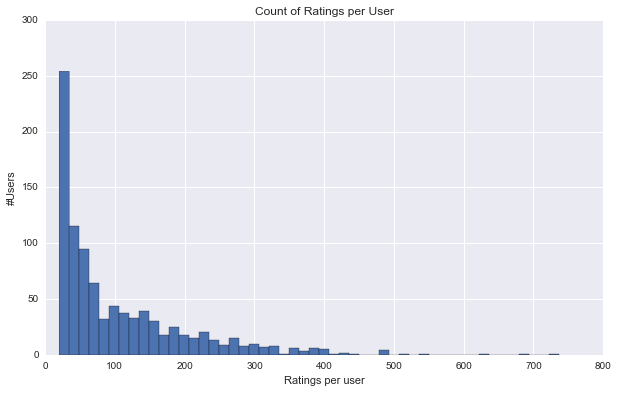

In [5]:
#Task t1b: Let us now analyze the rating behavior of the 1000 users in the dataset
#  Create a histogram based on the number of ratings per user with 50 bins. 
# Title="Count of Ratings per User", XLabel="Ratings per user", YLabel="#Users"

#t1b_user_rating_count is a groupby object that counts the number of ratings for each user.
t1b_user_rating_count = DataFrame(movielens_df.groupby(['UserId']).Rating.count())
# t1b_user_rating_count.columns = ['Ratings per user']
# print t1b_user_rating_count

figObj1b = t1b_user_rating_count.hist(bins = 50)
plt.title('Count of Ratings per User')
plt.xlabel('Ratings per user')
plt.ylabel('#Users')

####The figure below shows that most users leave less than 25 ratings while few outliers leave a lot of ratings

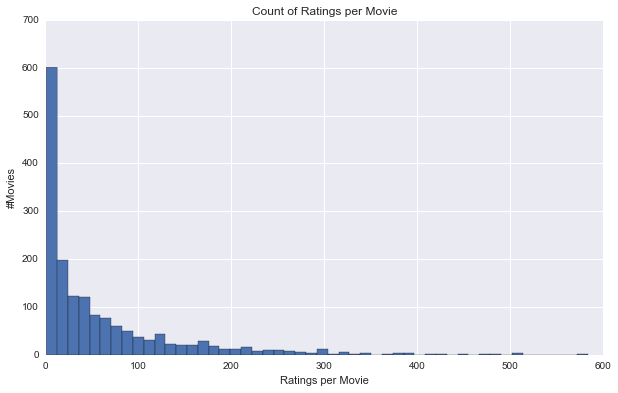

In [6]:
#Task t1c: Let us now analyze the rating behavior of the 1000 users in the dataset
#  Create a histogram based on the number of ratings per movie with 50 bins. 
# Title="Count of Ratings per Movie", XLabel="Ratings per Movie", YLabel="#Movies"

#t1c_user_rating_count is a groupby object that counts the number of ratings for each movie.
t1c_user_rating_count = DataFrame(movielens_df.groupby(['Title']).Rating.count())

figObj1c = t1c_user_rating_count.hist(bins = 50)
plt.title('Count of Ratings per Movie')
plt.xlabel('Ratings per Movie')
plt.ylabel('#Movies')

####The figure below shows that most movies receive less than 25 ratings while few popular get a lot of ratings

Average rating of ALL movies is 3.53


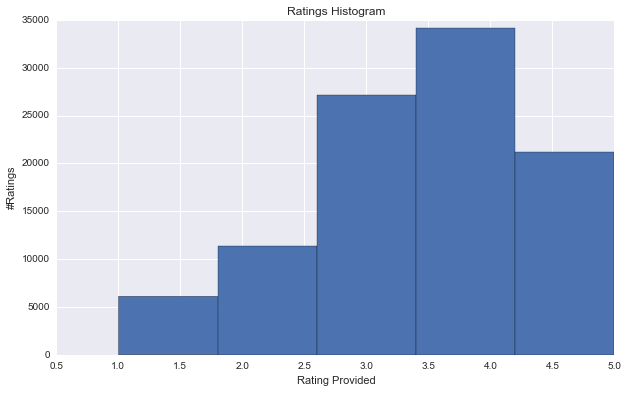

In [7]:
#Task t1d: Let us now analyze the rating distribution
#  Create a histogram based on the ratings received for each movie with 5 bins. 
# Title="Ratings Histogram", XLabel="Rating Provided", YLabel="#Ratings"

t1d_user_rating_count = movielens_df['Rating']
# print t1d_user_rating_count

figObj1d = t1d_user_rating_count.hist(bins = 5)
plt.title('Ratings Histogram')
plt.xlabel('Rating Provided')
plt.ylabel('#Ratings')

####The figure below shows that most movies at least 35K of ratings provided a score of 4 or higher.
#The code below shows that the average rating is 3.5
# This is problematic because each user has a different rating scale
# For some users 1 is a bad movie while for some others 3 is bad
# So a good model must take into the account the baseline rating behavior of users and movies

print "Average rating of ALL movies is", round(movielens_df.Rating.mean(),2)

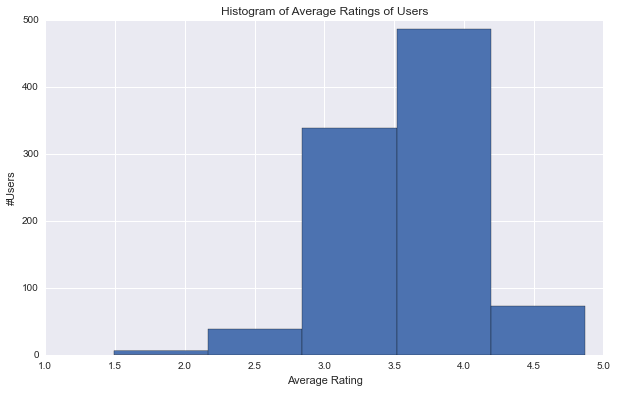

In [8]:
#Task t1e: Let us now study the baseline rating behavior in more detail
# For each user compute his/her average rating
#  Create a histogram based on the average ratings with 5 bins. 
# Title="Histogram of Average Ratings of Users", XLabel="Average Rating", YLabel="#Users"

#t1e_avg_ratings is a groupby object with average rating for each user
t1e_avg_ratings = DataFrame(movielens_df.groupby(['UserId']).Rating.mean())

figObj1e = t1e_avg_ratings.hist(bins = 5)
plt.title('Histogram of Average Ratings of Users')
plt.xlabel('Average Rating')
plt.ylabel('#Users')

####The figure below shows that while the average rating of users vary
# What does this imply?



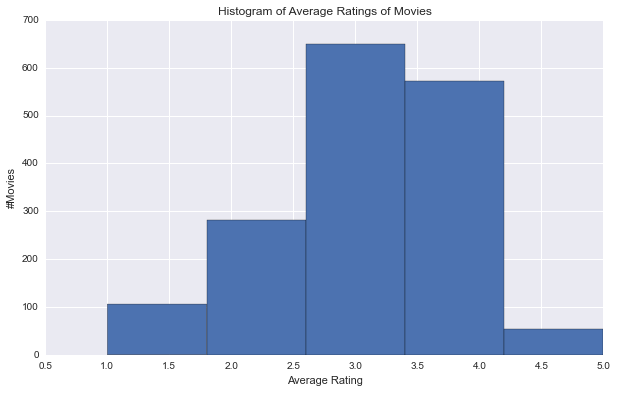

In [9]:
#Task t1f: Let us now study the baseline rating behavior in more detail
# For each movie compute its average rating
#  Create a histogram based on the average ratings with 5 bins. 
# Title="Histogram of Average Ratings of Movies", XLabel="Average Rating", YLabel="#Movies"

#t1e_avg_ratings is a groupby object with average rating for each user
t1f_avg_ratings = DataFrame(movielens_df.groupby(['Title']).Rating.mean())

figObj1f = t1f_avg_ratings.hist(bins = 5)
plt.title('Histogram of Average Ratings of Movies')
plt.xlabel('Average Rating')
plt.ylabel('#Movies')


####The figure below shows that while the average rating of movies vary
# What does this imply?



**Common Support**: The concept of common support is a key idea is recommender systems. Given two items (movies in our case), the common support is the number of reviewers who rated both items. It is useful in both K-nearest neighbor and collaborative filtering based recommenders. Specifically, if the common support is 0 for a pair of movies, then it is quite hard to find their similarity!

Average common support is  47.99


(array([  2.72600000e+03,   1.31000000e+03,   5.37000000e+02,
          1.97000000e+02,   9.50000000e+01,   5.50000000e+01,
          1.70000000e+01,   6.00000000e+00,   5.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   40.3,   79.6,  118.9,  158.2,  197.5,  236.8,  276.1,
         315.4,  354.7,  394. ]),
 <a list of 10 Patch objects>)

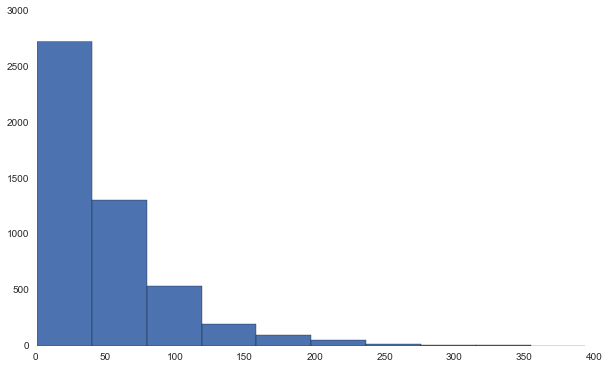

In [70]:
#Task t1g: Let us now analyze the common support for movielens dataset
# Here is the high level idea
# We are going to create an array and populate it with the common support for all pair of movies
# We then are going to plot a histogram and see its distribution.

#This task might take quite some time - 1-2 hours for typical machines !

#This contains all unique movies
t1g_all_movies = movies_df['MovieId'].unique()
#You will populate common support for all distinct pairs here
# Note that if you compared i,j you dont need to compare j and i again
t1g_allpair_commonsupport = []

#Your code to compute 
#t1g_all_movies = t1g_all_movies[:100]
# print t1g_all_movies
number_of_unique_movies = t1g_all_movies.size
# print number_of_unique_movies

# t1g_allpair_commonsupport = [-1]*number_of_unique_movies
# print t1g_allpair_commonsupport
                            
for i in range(number_of_unique_movies):
    
    # t= i+1
    # if t1g_allpair_commonsupport[i]==-1:
        # t1g_allpair_commonsupport[i] = 0
    
    for j in t1g_all_movies[i+1:]:
        c1 = movielens_df[movielens_df.MovieId.isin([i+1])]
        c2 = movielens_df[movielens_df.MovieId.isin([j])]
        count = 0
        for x in c1.UserId:
            for y in c2.UserId:
                if x == y:
                    count+=1
        t1g_allpair_commonsupport.append(count)
        # print t1g_allpair_commonsupport
                
#print t1g_allpair_commonsupport
            
print "Average common support is ", round(np.mean(t1g_allpair_commonsupport), 2)
plt.hist(t1g_allpair_commonsupport)

            



#### What the average common support and its distribution imply?

In [14]:
#Task t1h: Let us now consider how sparse the matrix is
from __future__ import division
number_of_user_rows, number_of_user_columns = users_df.shape
number_of_movie_rows, number_of_movie_columns = movies_df.shape
number_of_rating_rows, number_of_rating_columns = ratings_df.shape

# Numerator is number_of_rating_rows, Denominator is number_of_user_rows*number_of_movie_rows
# print number_of_user_rows, number_of_movie_rows, number_of_rating_rows

t1h_sparsity = number_of_rating_rows/(number_of_user_rows*number_of_movie_rows)
print "Sparsity of the dataset is ", t1h_sparsity

#This graph is actually less sparse than typical datasets for recommender systems
# which often have a sparsity much lower than 1%
# As discussed in the class, the sparsity imposes huge problem in terms of designing efficient and correct algorithms

Sparsity of the dataset is  0.0630466936422


In [15]:
#Task t1i: Compute the average rating for each movie grouped by gender
#  In other words, for each movie, compute the average rating given by men and women
# Hint: use a pivot table

movielens_df_m = movielens_df[movielens_df.Gender.isin(['M'])]
# print movielens_df_m
movielens_df_f = movielens_df[movielens_df.Gender.isin(['F'])]
# movielens_df_f
                                            
                                            
t1i_movielens_mean_ratings = DataFrame(movielens_df.groupby(['Title']).Rating.mean()) 
t1i_movielens_mean_ratings.columns = ['Mean']
# print t1i_movielens_mean_ratings[:10]
t1f_m = DataFrame(movielens_df_m.groupby(['Title']).Rating.mean())
t1f_m.columns = ['M']
# print t1f_m[:10]
t1f_f = DataFrame(movielens_df_f.groupby(['Title']).Rating.mean())
t1f_f.columns = ['F']
# print t1f_f[:10]
                                            
t1i_movielens_mean_ratings = DataFrame.join(t1i_movielens_mean_ratings, t1f_f)
# print t1i_movielens_mean_ratings[:10]
t1i_movielens_mean_ratings = DataFrame.join(t1i_movielens_mean_ratings, t1f_m)
# print t1i_movielens_mean_ratings[:10]
t1i_movielens_mean_ratings.drop('Mean', axis=1, inplace=True)
# print t1i_movielens_mean_ratings[:10]

display(t1i_movielens_mean_ratings[:10])

,F,M
Title,,
'Til There Was You (1997),2.200000,2.500000
1-900 (1994),1.000000,3.000000
101 Dalmatians (1996),3.116279,2.772727
12 Angry Men (1957),4.269231,4.363636
187 (1997),3.500000,2.870968
2 Days in the Valley (1996),3.235294,3.223684
"20,000 Leagues Under the Sea (1954)",3.214286,3.568966
2001: A Space Odyssey (1968),3.491228,4.103960
3 Ninjas: High Noon At Mega Mountain (1998),1.000000,1.000000


# Part 2: Nearest Neighbor based Recommender System

Let us now build a simple global recommendation system based on the nearest neighbor idea. 

In [20]:
import collections

#Task t2a: 
# Create a dictionary where key is Movie Name and value is id
#       You can either use the movies_df or read and parse the u.item file yourself
movie_name_to_id_dictionary = {}

movies_df = pd.read_csv('ml-100k/u.item', sep='|', names=['MovieId', 'Title'], usecols=range(2))
movies_list = movies_df.values.tolist()
keys=[m[1] for m in movies_list]
values=[m[0] for m in movies_list]

movie_name_to_id_dictionary = collections.OrderedDict(zip(keys,values))

#Write code to populate the movie names to this array
all_movie_names = keys

#Your code below

In [21]:
#Task t2b: Write a function that takes two inputs: 
#  movie_id: id of the movie and common_users: a set of user ids
# and returns the list of rows corresponding to their movie ratings 

def get_movie_reviews(movie_id, common_users):
    #Get a boolean vector for themovielens_dfns_dfs provided by users in common_users for movie movie_id
    # Hint: use the isin operator of Pandas
    mask = None
    
    #Create a subset of data where the mask is True i.e. only collect data from users who satisfy the condition above
    # Then sort them based on userid
    movie_ratings = None
    
    movie_ratings = movielens_df[(movielens_df.MovieId == movie_id) & (movielens_df.UserId.isin(list(common_users)))]
    
    #Do not change below
    #Return the unique set of ratings provided
    movie_ratings = movie_ratings[movie_ratings['UserId'].duplicated()==False]
    
    #Below 1 line added by Divya
    movie_ratings= movie_ratings.sort(['MovieId', 'UserId'] , ascending=[True, True])
    
    return movie_ratings

In [83]:
#Do not change below

#Here are some sample test cases for evaluating t2b
print "get_movie_reviews(1, set([1]))"
display( get_movie_reviews(1, set([1])) )

print "get_movie_reviews(1, set(range(1, 10)))"
display( get_movie_reviews(1, set(range(1, 10))) )

print "get_movie_reviews(100, set(range(1, 10)))"
display( get_movie_reviews(100, set(range(1, 10))) )

print "get_movie_reviews(784, set(range(1, 784)))"
display( get_movie_reviews(784, set(range(1, 784))) )




get_movie_reviews(1, set([1]))


,MovieId,Title,UserId,Rating,Age,Gender,Occupation,ZipCode
20103,1,Toy Story (1995),1,5,24,M,technician,85711


get_movie_reviews(1, set(range(1, 10)))


,MovieId,Title,UserId,Rating,Age,Gender,Occupation,ZipCode
20103,1,Toy Story (1995),1,5,24,M,technician,85711
15002,1,Toy Story (1995),2,4,53,F,other,94043
820,1,Toy Story (1995),5,4,33,F,other,15213
35865,1,Toy Story (1995),6,4,42,M,executive,98101


get_movie_reviews(100, set(range(1, 10)))


,MovieId,Title,UserId,Rating,Age,Gender,Occupation,ZipCode
20202,100,Fargo (1996),1,5,24,M,technician,85711
15009,100,Fargo (1996),2,5,53,F,other,94043
843,100,Fargo (1996),5,5,33,F,other,15213
35894,100,Fargo (1996),6,5,42,M,executive,98101
74830,100,Fargo (1996),7,5,57,M,administrator,91344


get_movie_reviews(784, set(range(1, 784)))


,MovieId,Title,UserId,Rating,Age,Gender,Occupation,ZipCode
18103,784,Beyond Bedlam (1993),13,1,47,M,educator,29206
67420,784,Beyond Bedlam (1993),405,1,22,F,healthcare,10019


In [22]:
#Task t2c: Let us now calculate the similarity between two movies
# based on the set of users who rated both movies
#Using euclidean distance is a bad idea - but simplifies the code

def calculate_similarity(movie_name_1, movie_name_2, min_common_users=0):
    
    movie1 = movie_name_to_id_dictionary[movie_name_1]
    movie2 = movie_name_to_id_dictionary[movie_name_2]
    
    #This is the set of UNIQUE user ids  who reviewed  movie1
    users_who_rated_movie1 = set((movielens_df[(movielens_df.MovieId == movie1)].UserId).tolist())
    
    #This is the set of UNIQUE user ids  who reviewed  movie2
    users_who_rated_movie2 = set((movielens_df[(movielens_df.MovieId == movie2)].UserId).tolist())
    
    #Compute the common users who rated both movies: 
    # hint convert both to set and do the intersection
    common_users = users_who_rated_movie1.intersection(users_who_rated_movie2)
    
    #Using the code you wrote in t2a, get the reviews for the movies and common users
    movie1_reviews = get_movie_reviews(movie1, common_users)
    movie2_reviews = get_movie_reviews(movie2, common_users)
    
    #Now you have the data frame for both movies
    # Use the euclidean_distances function from sklean (imported already)
    # to compute the distance between their rating values
    distance = euclidean_distances(movie1_reviews['Rating'].values, movie2_reviews['Rating'].values)

    if len(common_users) < min_common_users:
        return [[float('inf')]]
    return distance

In [23]:
#Do not change below
print calculate_similarity("Toy Story (1995)", "GoldenEye (1995)")
print calculate_similarity("GoldenEye (1995)", "Tomorrow Never Dies (1997)")
print calculate_similarity("Batman Forever (1995)", "Batman & Robin (1997)")

[[ 13.60147051]]
[[ 6.244998]]
[[ 4.12310563]]


In [24]:
#Task t2d: Given a movie, find the top-k most similar movies
# that have the lowest euclidean distance 

#Here is the high level logic:
#  for each movie in all_movie_names (Except the input movie name)
#    compute its similarity and store it in an array
#   return the k movies with the smallest distances
# remember to pass min_common_users to calculate_similarity
def get_top_k_similar_movies(input_movie_name, k=5, min_common_users=0):
    
    other_movies = [movie_name for movie_name in all_movie_names if movie_name != input_movie_name]
    similarity_list = []
    for movie in other_movies:
        similarity_list.append((calculate_similarity(input_movie_name, movie, min_common_users)[0][0], movie))
    
    similarity_list = sorted(similarity_list)
    
    return similarity_list[:k]

In [28]:

#print get_top_k_similar_movies("Toy Story (1995)", 10)
print "\nMovies similar to GoldenEye [25]", get_top_k_similar_movies("GoldenEye (1995)", 10, 25)
print "\nMovies similar to GoldenEye [50]", get_top_k_similar_movies("GoldenEye (1995)", 10, 50)
print "\nMovies similar to GoldenEye [100]", get_top_k_similar_movies("GoldenEye (1995)", 10, 100)
print "\n\n"

print "\nMovies similar to Usual Suspects [25]", get_top_k_similar_movies("Usual Suspects, The (1995)", 10, 25)
print "\nMovies similar to Usual Suspects [50]", get_top_k_similar_movies("Usual Suspects, The (1995)", 10, 50)
print "\nMovies similar to Usual Suspects [100]", get_top_k_similar_movies("Usual Suspects, The (1995)", 10, 100)
print "\n\n"

print "\nMovies similar to Batman Forever [25]", get_top_k_similar_movies("Batman Forever (1995)", 10, 25)
print "\nMovies similar to Batman Forever [50]", get_top_k_similar_movies("Batman Forever (1995)", 10, 50)
print "\nMovies similar to Batman Forever [100]", get_top_k_similar_movies("Batman Forever (1995)", 10, 100)
print "\n\n"

print "\nMovies similar to Shawshank Redemption [25]", get_top_k_similar_movies("Shawshank Redemption, The (1994)", 10, 25)
print "\nMovies similar to Shawshank Redemption [50]", get_top_k_similar_movies("Shawshank Redemption, The (1994)", 10, 50)
print "\nMovies similar to Shawshank Redemption [100]", get_top_k_similar_movies("Shawshank Redemption, The (1994)", 10, 100)
print "\n\n"



Movies similar to GoldenEye [25]

ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

#Task 3: Item based Collaborative Filtering

In this task, let us try to perform item based collaborative filtering. In spirit, it is very similar to what you already did for Task 2. With some minor changes, you can easily build an item based collaborative filtering recommenders.

In [29]:
#Do not change below
# By default euclidean distance can be give arbitrary values
# Let us "normalize" it by limit its value between 0 and 1 and slightly change the interpretation
# 0 means that the preferences are very different
# 1 means that preferences are identical
# For tasks 3 and 4, remember to use this function

#Vec1 and vec2 are vectors
def euclidean_distance_normed(vec1, vec2):
    if len(vec1) == 0:
        return 0.0
    euc_distance = euclidean_distances(vec1, vec2)[0][0]
    return 1.0 / (1.0 + euc_distance)

In [30]:
#Task t3a:
# In this task, you want to compute the similarity between two items
#  which in this case means ratings_df
# You can use code from 2c except that you must now call euclidean_distance_normed
#  when computing the distance

def calculate_similarity_normed(movie_name_1, movie_name_2, min_common_users=0):
    movie1 = movie_name_to_id_dictionary[movie_name_1]
    movie2 = movie_name_to_id_dictionary[movie_name_2]

    #This is the set of UNIQUE user ids  who reviewed  movie1
    users_who_rated_movie1 = set((movielens_df[(movielens_df.MovieId == movie1)].UserId).tolist())
    
    #This is the set of UNIQUE user ids  who reviewed  movie2
    users_who_rated_movie2 = set((movielens_df[(movielens_df.MovieId == movie2)].UserId).tolist())
     
    #Compute the common users who rated both movies: 
    # hint convert both to set and do the intersection
    common_users = users_who_rated_movie1.intersection(users_who_rated_movie2)

    #Using the code you wrote in t2a, get the reviews for the movies and common users
    movie1_reviews = get_movie_reviews(movie1, common_users)
    movie2_reviews = get_movie_reviews(movie2, common_users)
    
    #Do not change below
    
    #Now you have the data frame for both movies
    # Use the euclidean_distances function from sklean (imported already)
    # to compute the distance between their rating values
    distance = euclidean_distance_normed(movie1_reviews['Rating'].values, movie2_reviews['Rating'].values)

    if len(common_users) < min_common_users:
        return 0.0
    return distance

In [31]:
#Do not change below
print calculate_similarity_normed("Toy Story (1995)", "GoldenEye (1995)")
print calculate_similarity_normed("GoldenEye (1995)", "Tomorrow Never Dies (1997)")
print calculate_similarity_normed("Batman Forever (1995)", "Batman & Robin (1997)")

0.0684862527649
0.138026263116
0.195194101601


In [32]:
#Do not change below

#We are now going to create item-item similarity database
# Since our data is "small", we will use a non-traditional approach of using nested hashes
# In real-life, using something like databases or other data structures is far more preferable

#Here is the high level structure
#{
#    movie_name_1:  
#    { 
#        movie_name_2: similarity_between_movie_1_and_2, 
#        movie_name_3: similarity_between_movie_1_and_3, 
#        ....
#        movie_name_n: similarity_between_movie_1_and_n
#    },
#    movie_name_2:
#    {
#        movie_name_1: similarity_between_movie_2_and_1, 
#        movie_name_3: similarity_between_movie_2_and_3, 
#        ....
#        movie_name_n: similarity_between_movie_2_and_n
#    },
#    ....
#    movie_name_n:
#    {
#        movie_name_1: similarity_between_movie_n_and_1, 
#        movie_name_2: similarity_between_movie_n_and_2, 
#        ....
#        movie_name_n-1: similarity_between_movie_n_and_n-1
#    },
#}    
    

#Here is how to use this data structuere:

#To get similarity between movies
#   data[movie1][movie2]
#To get similarity between one movie and all others
#   data[movie1]

In [33]:
#DO not change below
#This hash stores the movie to movie 
# as described above
movie_similarity_hash = defaultdict(dict)

In [34]:
#Item based filtering is expensive as you need to compute similarity of all pairs of items
# for this dataset it is 1682*1682 ~ 28 lakh pairs or 2.8 million
# running all of them might take hours and close to a day
# instead let us run on a smaller dataset
# specifically, let us only focus on the top-250 movies based on ratings
# which is more manageable


#Task t3b: 
# Get the top-k movie names with most ratings
#Hint: use Counter class

def top_k_movie_names(k):
    movie_ratings_counter = Counter()
    
    #Your code below
    movie_ratings_counter.update(movielens_df['Title'].values)

    return movie_ratings_counter.most_common(k)

In [35]:
#Do not change below
print "Top-10", top_k_movie_names(10), "\n"
print "Top-25", top_k_movie_names(25), "\n"

Top-10 [('Star Wars (1977)', 583), ('Contact (1997)', 509), ('Fargo (1996)', 508), ('Return of the Jedi (1983)', 507), ('Liar Liar (1997)', 485), ('English Patient, The (1996)', 481), ('Scream (1996)', 478), ('Toy Story (1995)', 452), ('Air Force One (1997)', 431), ('Independence Day (ID4) (1996)', 429)] 

Top-25 [('Star Wars (1977)', 583), ('Contact (1997)', 509), ('Fargo (1996)', 508), ('Return of the Jedi (1983)', 507), ('Liar Liar (1997)', 485), ('English Patient, The (1996)', 481), ('Scream (1996)', 478), ('Toy Story (1995)', 452), ('Air Force One (1997)', 431), ('Independence Day (ID4) (1996)', 429), ('Raiders of the Lost Ark (1981)', 420), ('Godfather, The (1972)', 413), ('Pulp Fiction (1994)', 394), ('Twelve Monkeys (1995)', 392), ('Silence of the Lambs, The (1991)', 390), ('Jerry Maguire (1996)', 384), ('Chasing Amy (1997)', 379), ('Rock, The (1996)', 378), ('Empire Strikes Back, The (1980)', 367), ('Star Trek: First Contact (1996)', 365), ('Titanic (1997)', 350), ('Back to th

In [36]:
#Do not change below
top_250_movie_names = [item[0] for item in top_k_movie_names(250)]

In [37]:
#Task t3c:
#Use the following logic
#  for each movie in movie_names:
#    for all other movies in movie_names:
#      compute similarity between  two movies using calculate_similarity_normed
#      remember to pass min_common_users to that function
#  note that movie_similarity_hash is a defaultdict 
#  so similarity between movie1 and movie2 can be set as movie_similarity_hash[movie1][movie2]
#  btw, similarity in our case is commutative. 
#   i.e. similarity(movie1, movie2) = similarity(movie2, movie1)
#   so do not call the function twice !
# movie_names is an array that lists the movies for which you have to compute pairwise similarity
def compute_movie_to_movie_similarity(movie_names, min_common_users=0):
    #Your code below
    for movie in movie_names:
        other_movies = movie_names[movie_names.index(movie)+1:]
        for other_movie in other_movies:
            movie_similarity_hash[movie][other_movie] = calculate_similarity_normed(movie, other_movie, min_common_users)
            movie_similarity_hash[other_movie][movie] = movie_similarity_hash[movie][other_movie]

In [38]:
#Do not change below

#Let us first test if your code above is correct by testing against a small subset of data
movie_similarity_hash = defaultdict(dict)
# let use the top-10 movies
compute_movie_to_movie_similarity(top_250_movie_names[:10], min_common_users=0)

#Get similarity with 
display(movie_similarity_hash["Toy Story (1995)"])
display(movie_similarity_hash['Return of the Jedi (1983)'])

print movie_similarity_hash["Toy Story (1995)"]["Independence Day (ID4) (1996)"]

{'Air Force One (1997)': 0.05697049581409102,
 'Contact (1997)': 0.046577726053728993,
 'English Patient, The (1996)': 0.047393923678019305,
 'Fargo (1996)': 0.039703378843999403,
 'Independence Day (ID4) (1996)': 0.040932023773211611,
 'Liar Liar (1997)': 0.045702558661657698,
 'Return of the Jedi (1983)': 0.046005690800297719,
 'Scream (1996)': 0.048137743418679969,
 'Star Wars (1977)': 0.040475114406879495}

{'Air Force One (1997)': 0.047007646177349489,
 'Contact (1997)': 0.045210588948186241,
 'English Patient, The (1996)': 0.04318065266563334,
 'Fargo (1996)': 0.038852101069895194,
 'Independence Day (ID4) (1996)': 0.038974721601113524,
 'Liar Liar (1997)': 0.037548797615781393,
 'Scream (1996)': 0.041895006229997207,
 'Star Wars (1977)': 0.052554803633703538,
 'Toy Story (1995)': 0.046005690800297719}

0.0409320237732


In [39]:
#Do not change below
#Let us now test against top-250 most popular movies
#This might take 10-20 mins to run!
movie_similarity_hash = defaultdict(dict)
compute_movie_to_movie_similarity(top_250_movie_names, min_common_users=25)


In [40]:
#Do not change below
#Do this if you want to persist the data 

# Let us persist the movie-movie similarity data structure 
# that way you dont need to re-run the whole thing
#pickle is a serialization library in Python
# To persist/serialize, use the following line
pickle.dump(movie_similarity_hash, open("movie_similarity.pickle", "wb"))
# To deserialize, uncomment the following line 
#movie_similarity_hash = pickle.load( open( "movie_similarity.pickle", "rb" ) )


In [41]:
#Do not change below
for movie_name in top_250_movie_names[:10]:
    print "Top-10 most similar movies for ", movie_name, " :", 
    print sorted(movie_similarity_hash[movie_name].items(), key=operator.itemgetter(1), reverse=True)[:10]
    print "\n"


Top-10 most similar movies for  Star Wars (1977)  : [('Fly Away Home (1996)', 0.12613198362288319), ("Ulee's Gold (1997)", 0.084626326089585924), ('Good Will Hunting (1997)', 0.082402672566341831), ('Apt Pupil (1998)', 0.080920442903129275), ('Gattaca (1997)', 0.080069658725771431), ('Wag the Dog (1997)', 0.07979214086871815), ('Sling Blade (1996)', 0.079245895810613809), ('African Queen, The (1951)', 0.07871102875529136), ('Rainmaker, The (1997)', 0.07844773813482285), ('Maltese Falcon, The (1941)', 0.075254704849630052)]


Top-10 most similar movies for  Contact (1997)  : [('Philadelphia (1993)', 0.10230216299200159), ('Sling Blade (1996)', 0.094882133490771736), ('Fried Green Tomatoes (1991)', 0.093051003668180476), ('Room with a View, A (1986)', 0.092610094432975923), ('Maltese Falcon, The (1941)', 0.092175602102042759), ("Singin' in the Rain (1952)", 0.092175602102042759), ('Shine (1996)', 0.092175602102042759), ('Bound (1996)', 0.091747370480532636), ('Sneakers (1992)', 0.0917473

In [47]:
#Task t3d

#Before doing t3d, please complete t4a so that user_rating_hash is available
# this will make the code below easier

#In this task, we are going to predict the rating of a user u for a movie m using item based collaborative filtering
#Here is the high level logic:
# for each item i rated by this user:
#    s = similarity between i and input movie m 
#    if similarity between i and m is 0, ignore this item 
#    compute weighted rating for m based on i as rating for i * s
# compute the predicted rating as sum of all weighted ratings / sum of all similarities

def predict_rating_for_movie_icf(movie_similarity_hash, input_user_id, input_movie_name, movies_considered):
    total_weighted_rating = 0.0
    total_similarity= 0.0
        
    #Hint: movie_similarity_hash is a nested hash where user id is key and 
    #  all their rating as a dictionary  
    # this dictionary is ordered as moviename: rating

    #if this user has already rated the movie, return that rating
    if input_movie_name in user_rating_hash[input_user_id].keys():
        return user_rating_hash[input_user_id][input_movie_name]
    
    #For each movie the user has rated

        #if user rated some movie, but it is not in the subset of movies that we computed pairwise similarity
        # such as top-250, then do not consider it either
        # for this task, the input is in movies_considered 
        
        #compute similarity between movies
        #dont recompute = use the hash
        
        #Reject item if similarity is 0
                     
        #Compute weighted rating
        
        #update total_weighted_rating and total_similarity
        
    for movie in user_rating_hash[input_user_id]:
        if movie not in movies_considered:
            continue
        else:
            similarity = movie_similarity_hash[input_movie_name][movie]
            if similarity == 0:
                pass
            else:
                weighted_rating = similarity * user_rating_hash[input_user_id][movie]
                total_weighted_rating += weighted_rating
                total_similarity += similarity
            
    #Do not change below
    if total_similarity == 0.0:
        return 0.0
    
    return total_weighted_rating / total_similarity

In [48]:
#Do not change below
#Let us compute the rating for first 5 users for the top-20 movies that they have not seen
for user_id in range(1, 5+1):
    print user_id, [ (movie_name, 
                        round(predict_rating_for_movie_icf(movie_similarity_hash, user_id, movie_name, top_250_movie_names),2))
                       for movie_name in top_250_movie_names[:20] 
                        if movie_name not in user_rating_hash[user_id]]
           
#print movie_name, predict_rating_for_movie_icf(movie_similarity_hash, 1, 'Liar Liar (1997)', min_common_users=25)



1 [('Liar Liar (1997)', 3.83), ('English Patient, The (1996)', 3.87), ('Scream (1996)', 3.87), ('Air Force One (1997)', 3.87)]
2 [('Return of the Jedi (1983)', 3.91), ('Independence Day (ID4) (1996)', 3.85), ('Raiders of the Lost Ark (1981)', 3.92), ('Pulp Fiction (1994)', 3.93), ('Twelve Monkeys (1995)', 3.87), ('Silence of the Lambs, The (1991)', 3.91), ('Chasing Amy (1997)', 3.89), ('Rock, The (1996)', 3.86), ('Empire Strikes Back, The (1980)', 3.91), ('Star Trek: First Contact (1996)', 3.86)]
3 [('Star Wars (1977)', 2.95), ('Fargo (1996)', 2.92), ('English Patient, The (1996)', 2.92), ('Toy Story (1995)', 2.92), ('Independence Day (ID4) (1996)', 2.89), ('Raiders of the Lost Ark (1981)', 2.92), ('Godfather, The (1972)', 2.93), ('Pulp Fiction (1994)', 2.95), ('Twelve Monkeys (1995)', 2.94), ('Silence of the Lambs, The (1991)', 2.92), ('Jerry Maguire (1996)', 2.9), ('Rock, The (1996)', 2.89), ('Empire Strikes Back, The (1980)', 2.95), ('Star Trek: First Contact (1996)', 2.9)]
4 [('Far

In [49]:
#Task t3e: 
#Here is the pseudocode for recommending movies
# for each movie this user has not rated in movies_considered:
#           predict rating for this movie and this user using t4d
#  return the top-k movies
def recommend_movies_icf(input_user_id, movies_considered, movie_similarity_hash,
                             user_rating_hash, k=10, min_common_movies=5):
    predicted_ratings = []
    
    #Your code here
    for movie in [m for m in movies_considered if m not in user_rating_hash[input_user_id]]:
        predicted_ratings.append((predict_rating_for_movie_icf(movie_similarity_hash, input_user_id, movie, top_250_movie_names), movie))
    
    return sorted(predicted_ratings, reverse=True)[:k]

In [50]:
#Do not change below:

#Let us predict top-5 movies for first 10 users
for user_id in range(1,11):
    print user_id, recommend_movies_icf(user_id, top_250_movie_names, movie_similarity_hash, 
                               user_rating_hash, k=10, min_common_movies=5)

1 [(4.1925848292261962, 'Fly Away Home (1996)'), (4.0983740953356511, "Ulee's Gold (1997)"), (4.0853921793090748, 'Seven Years in Tibet (1997)'), (3.9897313336931295, 'Maltese Falcon, The (1941)'), (3.9879158866803466, 'Manchurian Candidate, The (1962)'), (3.9876557080885249, 'Cop Land (1997)'), (3.9782574914172879, 'Wag the Dog (1997)'), (3.978195449823783, "Singin' in the Rain (1952)"), (3.9776616970615382, 'Secrets & Lies (1996)'), (3.9561068860479827, 'Mother (1996)')]
2 [(4.0808708045508908, 'Cool Hand Luke (1967)'), (4.0758760619946868, 'Maltese Falcon, The (1941)'), (4.0533051054926501, 'Patton (1970)'), (4.0083596465934832, 'Reservoir Dogs (1992)'), (3.9881299279283864, 'Wag the Dog (1997)'), (3.9839921546749677, 'Bound (1996)'), (3.9765105208616371, 'Father of the Bride Part II (1995)'), (3.9734726233103057, 'Abyss, The (1989)'), (3.9617904510489481, 'Rumble in the Bronx (1995)'), (3.9401087977258875, 'Manchurian Candidate, The (1962)')]
3 [(4.0, 'Fly Away Home (1996)'), (3.20

#Task 4: User based Collaborative Filtering

In this task, let us try to perform user based collaborative filtering. 

In [51]:
#In order to simplify the coding, let us create a nested hash structure to store the user-rating data
# It will look as follows:
#{
#    u1: {movie_name_1:rating1, movie_name_2:rating2, ....}, 
#    ....
#    un: {movie_name_1:rating1, movie_name_2:rating2, ....}, 
#}

#Of course, we will only store the movies that the user rated
#Use the all_movie_names to convert movie id to movie name
# remember that Movielens uses 1 based indexing
# so the name of movieid i is in all_movie_names[i-1]

In [52]:
#Task t4a
#Create the data structure as discussed above
# here is the logic:
# for each line in file ml-100k/u.data:
#   set user_rating_hash[user][movie] = rating
# read the instructions above again!

def compute_user_rating_hash():
    user_rating_hash = defaultdict(dict)
    
    #Your code below    
    all_users = ratings_df.UserId.tolist()
    
    for user in all_users:
        movie_names = [all_movie_names[i-1] for i in ratings_df[(ratings_df.UserId == user)].MovieId.tolist()]
        ratings = ratings_df[(ratings_df.UserId == user)].Rating.tolist()
        user_rating_hash[user] = dict(zip(movie_names, ratings))
    
    return user_rating_hash

In [53]:
#Do not change below
user_rating_hash = compute_user_rating_hash()

In [54]:
#Do not change below
#How many users are there?
print len(user_rating_hash.keys())
#How many movies did each of the first 20 users rated?
print [len(user_rating_hash[i].keys()) for i in range(1,20+1)] 
#print the ratings of user 4
display(user_rating_hash[4])

943
[271, 61, 53, 24, 175, 208, 401, 59, 22, 184, 181, 51, 632, 98, 103, 140, 28, 277, 20, 48]


{'Air Force One (1997)': 5,
 'Assignment, The (1997)': 5,
 'Blues Brothers 2000 (1998)': 5,
 'Client, The (1994)': 3,
 'Conspiracy Theory (1997)': 3,
 'Contact (1997)': 5,
 'Cop Land (1997)': 5,
 'Desperate Measures (1998)': 5,
 'Event Horizon (1997)': 4,
 'In & Out (1997)': 5,
 'Incognito (1997)': 5,
 'Indiana Jones and the Last Crusade (1989)': 3,
 'Liar Liar (1997)': 5,
 'Lost Highway (1997)': 5,
 'Mimic (1997)': 3,
 "One Flew Over the Cuckoo's Nest (1975)": 4,
 'Scream (1996)': 4,
 'Seven (Se7en) (1995)': 4,
 'Spawn (1997)': 2,
 'Star Wars (1977)': 5,
 'Starship Troopers (1997)': 4,
 "Ulee's Gold (1997)": 5,
 'Wedding Singer, The (1998)': 5,
 'Wonderland (1997)': 5}

In [57]:
#Task t4b:
#We need to modify our logic for computing distance
#Here is the high level pseudocode:
# movie1 = movie names rated by user 1
# movie2 = movie names rated by user 2
# common movies = set intersection of movie1 and movie2
# if number of common movies is less than min_common_movies, return 0.0 [not 0]
# other wise create a vector with rating for common movies only
# compute euclidean distance between the vectors
# return 1 / (1+euclidean distace)

def compute_user_user_similarity(user_rating_hash, user_id_1, user_id_2, min_common_movies=0):
    #Get list of movie names rated by user 1. hint use keys function [see above for usage]
    
    movies_rated_by_user_1 = user_rating_hash[user_id_1].keys()
    movies_rated_by_user_2 = user_rating_hash[user_id_2].keys()
    
    #compute common movies
    common_movies = set(movies_rated_by_user_1).intersection(set(movies_rated_by_user_2))
    
    if len(common_movies) < min_common_movies:
        return 0.0
    
    common_movies = sorted(list(common_movies))
    
    #vector1 is the set of ratings for user1 for movies in common_movies
    vector1 = [user_rating_hash[user_id_1][movie] for movie in common_movies]
    #vector2 is the set of ratings for user2 for movies in common_movies
    vector2 = [user_rating_hash[user_id_2][movie] for movie in common_movies]
    
    #Compute distance and return 1.0/(1.0+distance)
    distance = euclidean_distances(vector1, vector2)[0][0]
    return 1.0 / ( 1.0 + distance)

In [ ]:
#Testing code
print [round(compute_user_user_similarity(user_rating_hash, 1, i),2) for i in range(1, 10+1)]
print [round(compute_user_user_similarity(user_rating_hash, 784, i),2) for i in range(1, 10+1)]

In [60]:
#Task t4c
#This function finds the k-most similar users 
#Here is the high level logic:
#  for each user in all_user_ids other than the input user id:
#     find similarity between this user and input_user_id and store as (similarity, other userid)
#     sort based on similarity
#  return top-k
# remember to pass min_common_movies
def top_k_most_similar_users(user_rating_hash, input_user_id, all_user_ids, k=10, min_common_movies=0):
    user_similarity = []
        
    #Your code below
    for user in all_user_ids:
        if user != input_user_id:
            user_similarity.append((compute_user_user_similarity(user_rating_hash, input_user_id, user, min_common_movies), user))

    user_similarity = sorted(user_similarity, key=lambda x: x[0])

    return sorted(user_similarity, reverse=True)[:k]

In [61]:
#Do not change below
all_user_ids = range(1, 943+1)
print top_k_most_similar_users(user_rating_hash, 1, all_user_ids, 10, 5)
print top_k_most_similar_users(user_rating_hash, 1, all_user_ids, 10, 10)
print top_k_most_similar_users(user_rating_hash, 812, all_user_ids, 10, 5)
print top_k_most_similar_users(user_rating_hash, 812, all_user_ids, 10, 20)

[(0.41421356237309509, 876), (0.36602540378443865, 105), (0.33333333333333331, 895), (0.33333333333333331, 282), (0.33333333333333331, 107), (0.3090169943749474, 842), (0.3090169943749474, 696), (0.3090169943749474, 520), (0.3090169943749474, 516), (0.3090169943749474, 433)]
[(0.3090169943749474, 516), (0.3090169943749474, 433), (0.3090169943749474, 359), (0.25, 800), (0.25, 691), (0.2402530733520421, 564), (0.2402530733520421, 549), (0.2402530733520421, 46), (0.23166247903553999, 941), (0.22400923773979589, 252)]
[(0.5, 816), (0.5, 768), (0.41421356237309509, 555), (0.41421356237309509, 4), (0.36602540378443865, 534), (0.36602540378443865, 314), (0.36602540378443865, 127), (0.36602540378443865, 38), (0.33333333333333331, 826), (0.33333333333333331, 727)]
[(0.21712927295533244, 451), (0.16396078054371141, 782), (0.13652705949581431, 721), (0.095840694682461411, 181), (0.0, 943), (0.0, 942), (0.0, 941), (0.0, 940), (0.0, 939), (0.0, 938)]


In [62]:
#Task t4d
#In this task, we are going to predict the rating of a user for a movie using user based collaborative filtering
#Here is the high level logic:
# for each user u in all_user_ids:
#    s= similarity between u and input_user_id [remember to pass min_common_movies]
#    if similairty is 0.0 ignore u
#    if u has not rated this movie, ignore again
#    suppose u has rated this movie with a value of r
#    i am now going to give a "weighted rating" as r*s
# compute the predicted rating as sum of all weighted ratings / sum of all similarities

def predict_rating_for_movie_ucf(user_rating_hash, input_user_id, movie_name, all_user_ids, min_common_movies=5):
    total_weighted_rating = 0.0
    total_similarity= 0.0

    #For each user id
    for user in all_user_ids:
        #except input_user_id 
        if user != input_user_id:
            #compute similarity between users
            similarity = compute_user_user_similarity(user_rating_hash, input_user_id, user, min_common_movies)
        
            #Reject user if similarity is 0
            if similarity != 0:  
                #reject user if (s)he has not rated the movie
                if movie_name in user_rating_hash[user].keys():
                    #Compute weighted rating
                    r = user_rating_hash[user][movie_name]
                    weighted_rating = r * similarity
                    #update total_weighted_rating and total_similarity
                    total_weighted_rating += weighted_rating
                    total_similarity += similarity
            
    #Do not change below
    if total_similarity == 0.0:
        return 0.0
    
    return total_weighted_rating / total_similarity

In [63]:
#Do not change below
all_user_ids = range(1, 943+1)
for user_id in range(1, 5+1):
    print "user_id = ", user_id
    print [ round(predict_rating_for_movie_ucf(user_rating_hash, user_id, all_movie_names[i], all_user_ids, min_common_movies=5),1)
          for i in range(1, 10+1)]
    print [ round(predict_rating_for_movie_ucf(user_rating_hash, user_id, all_movie_names[i], all_user_ids, min_common_movies=10),1)
          for i in range(1, 10+1)]
    print "\n"

user_id =  1
[3.2, 3.1, 3.6, 3.3, 3.8, 3.8, 4.0, 3.9, 3.9, 3.9]
[3.2, 3.1, 3.6, 3.3, 3.5, 3.8, 4.0, 3.9, 3.9, 3.8]


user_id =  2
[3.2, 3.1, 3.6, 3.3, 3.7, 3.8, 4.0, 3.9, 3.8, 3.9]
[3.2, 3.1, 3.6, 3.3, 3.5, 3.8, 4.1, 3.9, 3.8, 3.8]


user_id =  3
[3.2, 3.0, 3.6, 3.3, 3.4, 3.8, 3.9, 3.9, 3.8, 3.9]
[3.0, 2.8, 3.5, 3.1, 3.2, 3.8, 4.0, 3.9, 3.7, 3.8]


user_id =  4
[3.3, 3.0, 3.6, 3.4, 3.4, 3.8, 3.9, 3.9, 3.7, 3.9]
[3.2, 2.9, 3.4, 3.0, 2.8, 3.8, 4.0, 3.8, 3.5, 3.9]


user_id =  5
[3.2, 3.0, 3.5, 3.3, 3.6, 3.8, 4.0, 3.8, 3.8, 3.8]
[3.2, 3.0, 3.5, 3.3, 3.5, 3.8, 4.0, 3.8, 3.8, 3.8]




In [64]:
#Task t4e: 
#Here is the pseudocode for recommending movies
# for each movie this user has not rated:
#     for all other users:
#           predict rating for this movie and this user using t4d
#  return the top-k movies
def recommend_movies_ucf(user_rating_hash, all_user_ids, input_user_id, k=10, min_common_movies=5):
    predicted_ratings = []
    
    #Your code here
    for movie in [m for m in all_movie_names if m not in user_rating_hash[input_user_id]]:
        predicted_ratings.append(( predict_rating_for_movie_ucf(user_rating_hash, input_user_id, movie, all_user_ids, min_common_movies),
                                          movie))
    
    return sorted(predicted_ratings, reverse=True)[:k]

In [65]:
#Do not change below
all_user_ids = range(1, 943+1)

for user_id in range(1, 5):
    print recommend_movies_ucf(user_rating_hash, all_user_ids, user_id, k=10, min_common_movies=5)

[(5.0000000000000009, 'Saint of Fort Washington, The (1993)'), (5.0, 'They Made Me a Criminal (1939)'), (5.0, "Someone Else's America (1995)"), (5.0, 'Santa with Muscles (1996)'), (5.0, 'Prefontaine (1997)'), (5.0, 'Marlene Dietrich: Shadow and Light (1996) '), (5.0, 'Little City (1998)'), (5.0, 'Great Day in Harlem, A (1994)'), (5.0, 'Entertaining Angels: The Dorothy Day Story (1996)'), (5.0, 'Aiqing wansui (1994)')]
[(5.0000000000000009, 'Prefontaine (1997)'), (5.0, 'They Made Me a Criminal (1939)'), (5.0, 'Star Kid (1997)'), (5.0, "Someone Else's America (1995)"), (5.0, 'Santa with Muscles (1996)'), (5.0, 'Saint of Fort Washington, The (1993)'), (5.0, 'Marlene Dietrich: Shadow and Light (1996) '), (5.0, 'Great Day in Harlem, A (1994)'), (5.0, 'Entertaining Angels: The Dorothy Day Story (1996)'), (5.0, 'Aiqing wansui (1994)')]
[(5.0, 'Tough and Deadly (1995)'), (5.0, 'Star Kid (1997)'), (5.0, 'Santa with Muscles (1996)'), (5.0, 'Saint of Fort Washington, The (1993)'), (5.0, 'Marlene 

#Task 5: Latent Factor Models

In this task, let us try to find the simplest SVD based latent factor model.

In [70]:
number_of_users = 943
number_of_movies = 1682

ratings_matrix = sp.sparse.lil_matrix((number_of_users, number_of_movies))



In [75]:
#Task t5a: This task requires a different data structure and hence different from prior tasks.
# Here is the high level idea:
#  - Create a sparse matrix of type lil_matrix 
#  - populate it with the data from ratings file
#  - if user id i gave movie id j with a rating r, set matrix[i-1,j-1] to r 
# ie rows=users, col=movies
# Hint: If you are reading it from file, note that Python treats the data from file as a string
# so you might want to convert them to integer before inserting them.
with open("ml-100k/u.data","r") as f:
    for line in f:
        user_id, movie_id, rating, timestamp = line.split("\t")
        ratings_matrix[ int(user_id)-1, int(movie_id)-1] = int(rating)

In [79]:
print "Matrix shape is", ratings_matrix.shape
print "Number of non zero values", ratings_matrix.nnz
print "Number of non zero values", ratings_matrix.nonzero()

Matrix shape is (943, 1682)
Number of non zero values 158695
Number of non zero values (array([  0,   0,   0, ..., 942, 942, 942], dtype=int32), array([   0,    1,    2, ..., 1187, 1227, 1329], dtype=int32))


In [80]:
#Task t5b:
# Perform SVD on the ratings matrix
# Hint use the svds function imported above and not svd 
# K is the number of factors to have
def perform_svd(ratings_matrix, K=100):
    U, S, V = None, None, None
    return U, S, V

In [81]:
#Task t5c:
# Note that S is is an array and not a matrix
# Create a diagonal matrix where the diagonal matrix is populated from S
# For eg, if S = 2,4, 8
# then output must be
#  2 0 0
#  0 4 0
#  0 0 8

def construct_diagonal_matrix(S):
    return None

In [83]:
#Task t5d: 
# We are now going to reconstruct the matrix from the SVD that we have got
# new matrix = U S V 
# But its shape will be different as we only used the top-k factors
def reconstruct_low_rank_matrix(U, S, V):
    return None

In [84]:
#Task t5e:
# Using the reconstructed matrix, predict the rating of user to a movie
def predict_rating_svd(user_id, movie_id):
    return 0.0